<a href="https://colab.research.google.com/github/Exlie-Flyyi/CS5488_Group_Project/blob/main/5.3%20Model%20Building_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -U -q PyDrive

In [2]:
#!pip install -U -q PyDrive

In [ ]:
#!pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [5]:
%cd "CS5488_Group_Project"

/content/drive/MyDrive/Github/CS5488_Group_Project


In [6]:
#import sys
#sys.path.append('/content/drive/My Drive')

# pyspark SVM

In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold

## 1. Feature Engineering

### 1.1 Read cleaned data file

In [8]:
#df = pd.read_csv("fake_job_postings_most_freq_text_cleaned.csv")fake_job_postings_imputed_text_cleaned.csv
df = pd.read_csv("fake_job_postings_imputed_text_cleaned.csv")
df.head()

,Unnamed: 0,c_title,c_benefits,c_requirements,c_company_profile,c_description,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,0,marketing intern,NaN,experience content management major plus famil...,food groundbreaking award winning cooking site...,food fast growing james beard award winning on...,"US, NY, New York",0,1,0,Other,Internship,Information Technology and Services,Marketing,0
1,1,customer service cloud video production,get part team gain experience working located ...,expect key responsibility communicate client t...,cloud video production service cloud video pro...,organised focused vibrant awesome passion cust...,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,2,commissioning machinery assistant,NaN,implement commissioning commissioning rotary e...,valor service workforce meet need across priva...,client located houston actively seeking experi...,"US, IA, Wever",0,1,0,Full-time,Mid-Senior level,Information Technology and Services,Information Technology,0
3,3,account executive washington dc,culture collaborative creative environment pho...,education bachelor master business administrat...,passion improving quality life geography heart...,company environmental research passion improvi...,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,4,bill review manager,full,rn license state science nursing managerial ex...,global human capital management firm miami flo...,job title itemization review fort worth tx dep...,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


### 1.2 Add words# as features

In [9]:
cols = ["c_title", "c_company_profile", "c_description", "c_requirements", "c_benefits"]
for c in cols:
    df[c] = df[c].fillna("") #replace nan

def extract_features(df):    
    for c in cols:
        #df[c+"_len"] = df[c].apply(lambda x : len(str(x))) #
        df[c+"_wc"] = df[c].apply(lambda x : len(str(x.split()))) #

    
extract_features(df)

### 1.3 Different types in special columns

In [10]:
cat_cols = ["employment_type", "required_experience","industry", "function"]
#,"industry", "function"
for c in cat_cols:
    encoded = pd.get_dummies(df[c]) 
    encoded.rename(columns=lambda x:x+c, inplace=True)
    df = pd.concat([df, encoded], axis=1) 

### 1.4 Drop unnecessary columns

In [11]:
drop_cols = ['c_title', 'location','c_company_profile', 'c_description', 'c_requirements', 'c_benefits']
drop_cols += cat_cols
df = df.drop(drop_cols, axis = 1)
df.head()

,Unnamed: 0,telecommuting,has_company_logo,has_questions,fraudulent,c_title_wc,c_company_profile_wc,c_description_wc,c_requirements_wc,c_benefits_wc,...,Public Relationsfunction,Purchasingfunction,Quality Assurancefunction,Researchfunction,Salesfunction,Sciencefunction,Strategy/Planningfunction,Supply Chainfunction,Trainingfunction,Writing/Editingfunction
0,0,0,1,0,0,23,661,575,563,2,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,55,647,1518,1011,876,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,43,598,284,1080,2,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,44,457,1767,1028,526,...,0,0,0,0,1,0,0,0,0,0
4,4,0,1,1,0,29,1295,1031,475,8,...,0,0,0,0,0,0,0,0,0,0


### 1.5 Data normalization

In [12]:
# normalization
cols = ["c_title_wc", "c_company_profile_wc", "c_description_wc", "c_requirements_wc", "c_benefits_wc"]
#dd = df
for c in cols:
    df[c] =  (df[c] - df[c].min()) / (df[c].max() - df[c].min())
#norm_duration = (df - data.duration.min()) / (data.duration.max() - data.duration.min())
df

,Unnamed: 0,telecommuting,has_company_logo,has_questions,fraudulent,c_title_wc,c_company_profile_wc,c_description_wc,c_requirements_wc,c_benefits_wc,...,Public Relationsfunction,Purchasingfunction,Quality Assurancefunction,Researchfunction,Salesfunction,Sciencefunction,Strategy/Planningfunction,Supply Chainfunction,Trainingfunction,Writing/Editingfunction
0,0,0,1,0,0,0.120000,0.149671,0.045204,0.062333,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0.302857,0.146491,0.119596,0.112111,0.254588,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0.234286,0.135362,0.022247,0.119778,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0.240000,0.103339,0.139240,0.114000,0.152636,...,0,0,0,0,1,0,0,0,0,0
4,4,0,1,1,0,0.154286,0.293663,0.081177,0.052556,0.001748,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17491,17875,0,1,1,0,0.211429,0.319328,0.073209,0.092000,0.179726,...,0,0,0,0,1,0,0,0,0,0
17492,17876,0,1,1,0,0.131429,0.326823,0.084411,0.072111,0.078066,...,0,0,0,0,0,0,0,0,0,0
17493,17877,0,0,0,0,0.422857,0.042925,0.082518,0.096222,0.000000,...,0,0,0,0,0,0,0,0,0,0
17494,17878,0,0,1,0,0.120000,0.000000,0.026270,0.047667,0.054180,...,0,0,0,0,0,0,0,0,0,0


### 1.6 Create SparkSession and convert Pandas Dataframe to PySpark DataFrame

In [13]:
#!pip install pyspark

In [14]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("svm_2") \
    .getOrCreate()
sparkContext=spark.sparkContext
df_from_pandas=spark.createDataFrame(df) 
df_from_pandas=df_from_pandas.withColumnRenamed("Unnamed: 0", "doc")
#df_from_pandas.printSchema()
#df_from_pandas.show(1)

In [15]:
#df_from_pandas.printSchema()

### 1.7 Create TF IDF Features

Read data from results of TFIDF processing step based on Hadoop

In [16]:
from pyspark.sql.functions import split, col,substring,regexp_replace
#tfidf_path = "TFIDF_Hadoop/output3/part-r-00000"
tfidf_path = "TFIDF_Hadoop/part-r-00000"
s = StructType() \
                    	.add("word@doc", "string")\
                    	.add("score", "float")
tfidf=spark.read.csv(tfidf_path, sep="\t", schema=s)
tfidf = tfidf.withColumn('word', split(tfidf['word@doc'], '@').getItem(0)) \
       .withColumn('doc', split(tfidf['word@doc'], '@').getItem(1)).drop('word@doc')
#tfidf.show(5)

Get and select the top 1000 most frequent words

In [17]:
from pyspark.sql.functions import sum, col, desc
Day_count = tfidf.groupby('word').count()
#features 500 1000 1500
top = Day_count.orderBy(desc('count')).take(1000)
deptDF = spark.createDataFrame(data=top)
#deptDF.show(5)
deptDF = deptDF.select('word').rdd.flatMap(lambda x: x).collect()
resultDf = tfidf.filter(tfidf.word.isin(deptDF))
#resultDf.show(5)

Create a spreadsheet-style pivot table as a DataFrame from tfidf

In [18]:
pivotDF = resultDf.groupBy("doc").pivot("word").sum("score")
pivotDF = pivotDF.fillna(0)
#pivotDF.show(5)

### 1.8 Merge the features of tfidf with other features

In [19]:
#pivotDF = pivotDF.merge(sparkDF, on='doc',how='right')
#df_from_pandas_l = df_from_pandas.select(col("doc"),col("fraudulent"))
new_df = df_from_pandas.join(pivotDF, on='doc', how='left_outer')
new_df=new_df.fillna(0)

#new_df.show(5)

In [20]:
#new_df.printSchema()

In [21]:
#combined_df.show(5)

### 1.9 Created the feature vector

In [22]:
#Library that contains the functions for building vectors
from pyspark.ml.linalg import Vectors  
from pyspark.ml.feature import VectorAssembler 
#Created the feature vector

idd, target = "doc", "fraudulent"
#not over
features = [f for f in new_df.columns if f not in [idd, target]]
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
df_temp = vector_assembler.transform(new_df)
#over combined_df
#features = [f for f in combined_df.columns if f not in [idd, target]]
#vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
#df_temp = vector_assembler.transform(combined_df)

In [23]:
#df_temp.printSchema()

### 1.10 select label and feature columns

In [24]:
from pyspark.sql.functions import col
df_formatted = df_temp.select(col("fraudulent"),col("features"))
df_formatted.printSchema()
#df_formatted.show(5)

root
 |-- fraudulent: long (nullable = true)
 |-- features: vector (nullable = true)



In [25]:
df_SVM=df_formatted.selectExpr('features',"fraudulent as label")
#df_SVM.show(2)

In [26]:
#df_SVM.show(2)

In [27]:
df_SVM.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



In [28]:
#import pyspark.sql.functions as F
#df_SVM=df_SVM.where((F.col("label") == 0) | (F.col("label") == 1))  #Transforms the dataset into a binary sorting problem

### 1.11 Splits between training and testing data

In [29]:
#Splits between training and testing data
(train, test) = df_SVM.randomSplit([0.8, 0.2])
#train.show(10)

In [30]:
#yes = test.filter(col("label") == 1)
#print(yes.count())
#no = test.filter(col("label") == 0)
#print(no.count())

In [31]:
#oversampled_df just for training data fix it!!!!!
##!!!!!!!!!!
from pyspark.sql.functions import col, explode, array, lit
import math
major_df = train.filter(col("label") == 0)
minor_df = train.filter(col("label") == 1)
#Expansion multiple
time = 1
#ratio = int(major_df.count()/minor_df.count()/time)
ratio = 19
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
oversampled_train = major_df.unionAll(oversampled_df)


In [32]:
#yes = oversampled_train.filter(col("label") == 1)
##print("Real job in training set: "+str(yes.count()))
#no = oversampled_train.filter(col("label") == 0)
#print("Fake job in training set: "+str(no.count()))

## 2. Defines the SVM Model

### 2.1 seperate training data and testing data

In [33]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel  #Library for SVM Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  #Used to find performance metrics
from pyspark.mllib.linalg import Vectors  #Dense vectors
from pyspark.mllib.util import MLUtils
#oversampled_train 
df_train = MLUtils.convertVectorColumnsFromML(oversampled_train, "features")
#origin_train
#df_train = MLUtils.convertVectorColumnsFromML(train, "features")
df_test = MLUtils.convertVectorColumnsFromML(test, "features")

In [34]:
#df_train.show(5,False)

### 2.2 Apply the label

In [35]:
from pyspark.mllib.regression import LabeledPoint  #Creates the "line" (characteristics and label) to be used

trainingData = df_train.rdd.map(lambda row:LabeledPoint(row.label,row.features))  #Apply the label to the training
testingData = df_test.rdd.map(lambda row:LabeledPoint(row.label,row.features))  #Apply the label to the test

In [36]:
#for xs in trainingData.take(10):
 #   print(xs)
 

### 2.3 Model build

In [37]:
# 将数据暂存在内存中，加快后续运算效率
#Set this RDD's storage level to persist its values across operations
#after the first time it is computed. This can only be used to assign
#a new storage level if the RDD does not have a storage level set yet.
#If no storage level is specified defaults to (MEMORY_ONLY).
trainingData.persist()
testingData.persist()

PythonRDD[95] at RDD at PythonRDD.scala:53

In [38]:
#Model build
modelSVM = SVMWithSGD.train(trainingData, iterations=1000,step = 0.01)

### 2.4 Performing the prediction

In [39]:
#labelsAndPreds = testingData.map(lambda p: (p.label, modelSVM.predict(p.features)))
#print(labelsAndPreds[0])

In [40]:
#Performing the prediction
labelsAndPreds = testingData.map(lambda p: (p.label, modelSVM.predict(p.features)))
def evaluation(labelsAndPreds):
    tp = labelsAndPreds.filter(lambda lp: lp[0] == 1.0 and lp[1] == 1).count()
    fn = labelsAndPreds.filter(lambda lp: lp[0] == 1.0 and lp[1] == 0).count()
    fp = labelsAndPreds.filter(lambda lp: lp[0] == 0.0 and lp[1] == 1).count()
    tn = labelsAndPreds.filter(lambda lp: lp[0] == 0.0 and lp[1] == 0).count()
    #a = labelsAndPreds.filter(lambda lp: lp[0] == 0.0).count()
    #b = labelsAndPreds.filter(lambda lp: lp[0] == 1.0).count()
    p = tp + fn
    n = fp + tn
    #print(tp)
    #print(fn)
    #print(fp)
    #print(tn)
    acc = (tp+tn)/(p+n)
    if tp+fp != 0 : precision = tp/(tp+fp)
    else: precision = 0
    recall = tp/p
    F1_score = 2*tp/(2*tp+fp+fn)
    return tp,fn,fp,tn,acc,precision,recall,F1_score

tp,fn,fp,tn,acc,precision,recall,F1_score = evaluation(labelsAndPreds)
print("accuracy: ",acc)
print("precision: ",precision)
print("recall: ",recall)
print("F1_score: ",F1_score)

accuracy:  0.9621653084982538
precision:  0.6756756756756757
recall:  0.17482517482517482
F1_score:  0.2777777777777778


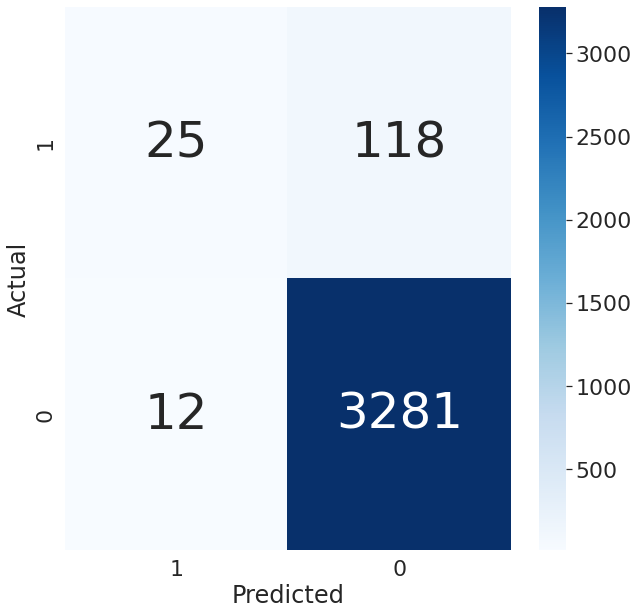

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
'''tp = 132
fn = 46
fp = 612
tn = 2797
p = tp + fn
n = fp + tn
acc = (tp+tn)/(p+n)
precision = tp/(tp+fp)
recall = tp/p
F1_score = 2*tp/(2*tp+fp+fn)
print("accuracy: ",acc)
print("precision: ",precision)
print("recall: ",recall)
print("F1_score: ",F1_score)'''
cm_tv = pd.DataFrame({
  '1': [tp, fp],
  '0': [fn, tn]},
  index=['1','0']
  )
#print(cm_tv)132 46 612 2797
cm_tv = pd.DataFrame(cm_tv)
cm_tv.index.name = 'Actual'
cm_tv.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.set(font_scale=2)
sns.heatmap(cm_tv,cmap= "Blues",annot = True, fmt='',annot_kws={"size":50})

Model parameter tuning

In [42]:
def evaluation(labelsAndPreds):
    tp = labelsAndPreds.filter(lambda lp: lp[0] == 1.0 and lp[1] == 1).count()
    fn = labelsAndPreds.filter(lambda lp: lp[0] == 1.0 and lp[1] == 0).count()
    fp = labelsAndPreds.filter(lambda lp: lp[0] == 0.0 and lp[1] == 1).count()
    tn = labelsAndPreds.filter(lambda lp: lp[0] == 0.0 and lp[1] == 0).count()
    #a = labelsAndPreds.filter(lambda lp: lp[0] == 0.0).count()
    #b = labelsAndPreds.filter(lambda lp: lp[0] == 1.0).count()
    p = tp + fn
    n = fp + tn
    #print(tp)
    #print(fn)
    #print(fp)
    #print(tn)
    acc = (tp+tn)/(p+n)
    if tp+fp != 0 : precision = tp/(tp+fp)
    else: precision = 0
    recall = tp/p
    F1_score = 2*tp/(2*tp+fp+fn)
    return tp,fn,fp,tn,acc,precision,recall,F1_score

In [43]:
## 创建trainEvaluateModel函数包含训练与评估功能，并计算训练评估的时间。
from time import time

def trainEvaluateModel(trainData1, testingData1, iterations, step):
    startTime = time()
    ## Model build
    modelSVM1 = SVMWithSGD.train(trainData1, iterations=iterations, step=step)
    ## Performing the prediction and evaluation
    labelsAndPreds = testingData1.map(lambda p: (p.label, modelSVM1.predict(p.features)))
    tp,fn,fp,tn,acc,precision,recall,F1_score = evaluation(labelsAndPreds)
    #accuracy = ModelAccuracy(Model, validationData)

    duration = time() - startTime   # 持续时间
    print("parameter: "+"iterations="+str(iterations) + 
         ",  step="+str(step)+"\n"+
         "===>time="+str(duration)+", accuracy="+str(acc)+", precision="+str(precision)+", recall="+str(recall)+", F1_score="+str(F1_score))
    return acc, duration, precision,recall,F1_score, iterations, step, modelSVM


In [44]:
## Define the function gridSearch to search for the best combination of parameters
## parameter combination
iterationsList = [10,100,1000,10000] 
stepList = [0.01, 0.1, 1, 10]
def gridSearch(trainData, testingData, iterationsList, stepList):
    metrics = [trainEvaluateModel(trainData, testingData,iterations, step)
          for iterations in iterationsList
          for step in stepList]
    # Sort according to F1_score from large to small, and return the parameter combination with the maximum F1_score
    sorted_metics = sorted(metrics, key=lambda k:k[4], reverse=True)
    best_parameters = sorted_metics[0]
    print("\nbest parameter combination："+"iterations = "+str(best_parameters[5]) + 
         ", step="+str( best_parameters[6])+"\n"+ "F1_score="+str( best_parameters[4]))
    return  best_parameters



## best combination of parameters
best_parameters = gridSearch(trainingData, testingData, iterationsList, stepList)